# Emmanuel Nhyira CNN-LSTM implemantation
# Adopted from M. H. Abdelaziz, W. A. Mohamed, and A. S. Selmy, “Hand Gesture Recognition Based on Electromyography Signals and Deep Learning Techniques”, doi: 10.12720/jait.15.2.255-263.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import scipy.io

#loading data
path = '/content/drive/MyDrive/Session1_converted'
subject_id = 0
data = scipy.io.loadmat(f'{path}/session1_participant{subject_id+1}.mat')  #files are usually numbered 1.mat, 2.mat, etc.

#extracting forearm EMG data
data_forearm = data['DATA_FOREARM']  # shape: (7 trials, 17 gestures)


In [ ]:
data_forearm.shape

(7, 17)

In [ ]:
#target gestures(zero-indexed)
target_gesture_indices = [6, 14, 15, 16]  #'Index and Middle Finger Extension', 'Hand Open', 'Hand Close', 'Rest'

#channels to keep(zero-indexed: 0,1,6)
selected_channels = [0, 1, 6]

#window settings
sampling_rate = 1000  # After downsampling
window_size = int(0.2 * sampling_rate)  # 200ms windows to 200 samples

def preprocess_emg(window, sampling_rate=1000):
    #mean removal (zero-mean)
    window = window - np.mean(window, axis=0)

    #full-wave rectification (absolute value)
    window = np.abs(window)

    #moving average smoothing (10ms window = 10 samples at 1000 Hz)
    window_size_smooth = int(0.01 * sampling_rate)
    smoothed_window = np.zeros_like(window)
    for ch in range(window.shape[1]):
        smoothed_window[:, ch] = np.convolve(window[:, ch], np.ones(window_size_smooth)/window_size_smooth, mode='same')

    #normalization (0 to 1 scaling per channel)
    min_vals = np.min(smoothed_window, axis=0)
    max_vals = np.max(smoothed_window, axis=0)
    normalized_window = (smoothed_window - min_vals) / (max_vals - min_vals + 1e-8)

    return normalized_window


In [ ]:
X = []
y = []

for gesture_idx in target_gesture_indices:
    #concatenating all 7 trials
    concatenated_emg = []

    for trial_idx in range(7):
        emg_data = data_forearm[trial_idx, gesture_idx]  #shape: (10240, 16)

        #downsampling from 2048 Hz to 1000 Hz (by taking every second sample)
        emg_data_downsampled = emg_data[::2]

        #only selected channels
        emg_data_selected = emg_data_downsampled[:, selected_channels]  # shape: (5120, 3)

        concatenated_emg.append(emg_data_selected)

    #stacking all trials vertically to (5120*7, 3) = (35840, 3)
    gesture_data = np.vstack(concatenated_emg)

    #non-overlapping windows
    num_windows = gesture_data.shape[0] // window_size

    for i in range(0, num_windows * window_size, window_size):
        window = gesture_data[i:i + window_size, :]  # shape: (200, 3)

        #preprocess
        window_processed = preprocess_emg(window, sampling_rate=1000)

        X.append(window_processed)
        y.append(target_gesture_indices.index(gesture_idx))  # Label: 0,1,2,3

#converting to numpy arrays
X = np.array(X)  #(num_samples, 200, 3)
y = np.array(y)  #(num_samples,)

print("Final dataset shapes:", X.shape, y.shape)

Final dataset shapes: (716, 200, 3) (716,)


In [ ]:
X

array([[[2.67213840e-02, 0.00000000e+00, 2.15159934e-04],
        [1.42152369e-01, 1.06550306e-01, 6.99723156e-02],
        [1.90097849e-01, 1.66018948e-01, 9.20303394e-02],
        ...,
        [4.33699122e-02, 1.48614659e-01, 1.26837902e-02],
        [2.58726820e-02, 8.57154199e-02, 5.81386044e-03],
        [0.00000000e+00, 1.37850446e-02, 0.00000000e+00]],

       [[5.03246096e-01, 2.44868374e-01, 5.53497928e-01],
        [5.29875487e-01, 2.64742312e-01, 6.05953958e-01],
        [6.33827736e-01, 3.28168288e-01, 7.00006103e-01],
        ...,
        [1.75006508e-01, 2.02788271e-01, 2.23176309e-01],
        [1.72787562e-01, 1.90505993e-01, 2.12029627e-01],
        [1.57400544e-01, 1.67236286e-01, 1.79682041e-01]],

       [[1.41932295e-01, 5.93722744e-01, 5.08116714e-02],
        [1.70664616e-01, 6.25730992e-01, 7.32316263e-02],
        [2.90194845e-01, 6.98144830e-01, 1.77280880e-01],
        ...,
        [2.80921365e-02, 2.39803107e-02, 1.95429049e-02],
        [2.07428501e-02, 1.12

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

#converting X and y numpy arrays into PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

#TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

#splitting dataset into train, val, test (60%, 20%, 20%)
dataset_size = len(dataset)
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  #set seed for reproducibility
)

#dataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

Train batches: 7, Val batches: 3, Test batches: 3


In [ ]:
import torch
import torch.nn as nn

class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()

        #CNN Feature extractor
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2),  #(batch, 16, seq_len)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),  #(batch, 16, seq_len/2)

            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),  #(batch, 32, seq_len/2)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)   #(batch, 32, seq_len/4)
        )

        #LSTM Sequence Modeler
        self.lstm = nn.LSTM(input_size=32, hidden_size=64, num_layers=1, batch_first=True)

        #final classification layer
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        #x shape: (batch, channels, sequence_length)
        x = self.cnn_layers(x)

        #prepare for LSTM: (batch, sequence_length, features)
        x = x.permute(0, 2, 1)

        #pass through LSTM
        out, (hn, cn) = self.lstm(x)

        #take only last LSTM output for classification
        out = out[:, -1, :]  #(batch, hidden_size)

        out = self.fc(out)
        return out

In [ ]:
#defining model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM(num_classes=4).to(device)  #change num_classes as depending on the number of gestures you want to recognize

In [ ]:
import torch.optim as optim
#loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#training loop
num_epochs = 300

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1)  # (batch_size, channels=3, seq_len=200)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    #validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # (batch_size, channels=3, seq_len=200)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch [1/300], Train Loss: 1.3904, Train Acc: 0.2634, Val Loss: 1.3852, Val Acc: 0.2937
Epoch [2/300], Train Loss: 1.3877, Train Acc: 0.2634, Val Loss: 1.3839, Val Acc: 0.2937
Epoch [3/300], Train Loss: 1.3864, Train Acc: 0.2634, Val Loss: 1.3828, Val Acc: 0.2937
Epoch [4/300], Train Loss: 1.3859, Train Acc: 0.2541, Val Loss: 1.3827, Val Acc: 0.2797
Epoch [5/300], Train Loss: 1.3847, Train Acc: 0.2704, Val Loss: 1.3829, Val Acc: 0.2587
Epoch [6/300], Train Loss: 1.3831, Train Acc: 0.2914, Val Loss: 1.3836, Val Acc: 0.2587
Epoch [7/300], Train Loss: 1.3833, Train Acc: 0.2727, Val Loss: 1.3843, Val Acc: 0.2867
Epoch [8/300], Train Loss: 1.3824, Train Acc: 0.2611, Val Loss: 1.3852, Val Acc: 0.2587
Epoch [9/300], Train Loss: 1.3809, Train Acc: 0.2914, Val Loss: 1.3872, Val Acc: 0.2587
Epoch [10/300], Train Loss: 1.3767, Train Acc: 0.3030, Val Loss: 1.3907, Val Acc: 0.2098
Epoch [11/300], Train Loss: 1.3734, Train Acc: 0.3054, Val Loss: 1.3960, Val Acc: 0.2238
Epoch [12/300], Train Loss: 1.

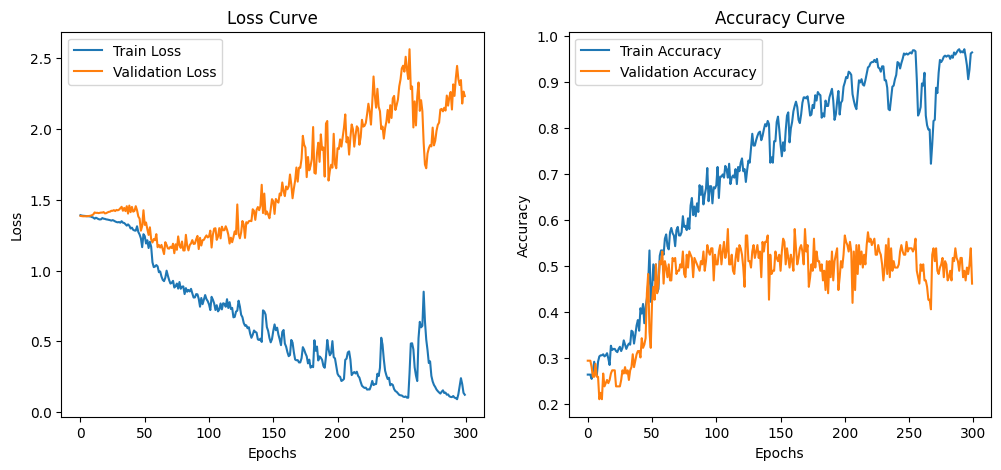

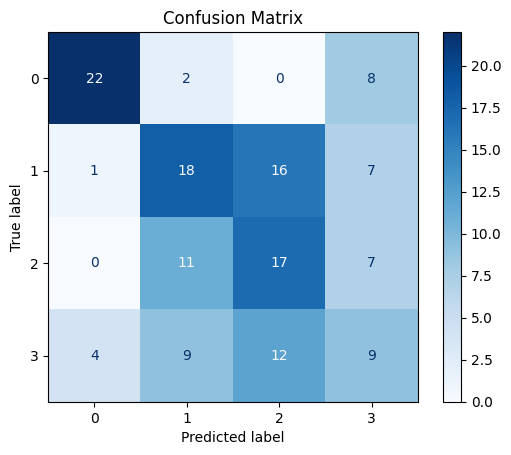

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 5. Plot Loss and Accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 6. Plot Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#hyperparameter grids
learning_rates = [0.001, 0.0005]
optimizers_list = ['Adam', 'SGD']
batch_sizes = [32, 64]

#recording best model
best_val_acc = 0.0
best_hyperparams = {}

#device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for lr in learning_rates:
    for opt_name in optimizers_list:
        for batch_size in batch_sizes:
            #dataLoaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            #model
            model = CNN_LSTM(num_classes=4).to(device)

            #loss
            criterion = nn.CrossEntropyLoss()

            #optimizer
            if opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif opt_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            #training
            num_epochs = 30
            for epoch in range(num_epochs):
                model.train()
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    inputs = inputs.permute(0, 2, 1)  # (batch_size, channels=3, seq_len=200)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            #validation
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    inputs = inputs.permute(0, 2, 1)  # (batch_size, channels=3, seq_len=200)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100 * correct / total

            print(f"lr={lr}, optimizer={opt_name}, batch_size={batch_size} => Val Acc: {val_acc:.2f}%")

            #save best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_hyperparams = {'lr': lr, 'optimizer': opt_name, 'batch_size': batch_size}

print("\nBest Hyperparameters:", best_hyperparams)
print("Best Validation Accuracy:", best_val_acc)

lr=0.001, optimizer=Adam, batch_size=32 => Val Acc: 30.77%
lr=0.001, optimizer=Adam, batch_size=64 => Val Acc: 25.17%
lr=0.001, optimizer=SGD, batch_size=32 => Val Acc: 23.78%
lr=0.001, optimizer=SGD, batch_size=64 => Val Acc: 29.37%
lr=0.0005, optimizer=Adam, batch_size=32 => Val Acc: 23.78%
lr=0.0005, optimizer=Adam, batch_size=64 => Val Acc: 26.57%
lr=0.0005, optimizer=SGD, batch_size=32 => Val Acc: 30.77%
lr=0.0005, optimizer=SGD, batch_size=64 => Val Acc: 23.78%

Best Hyperparameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32}
Best Validation Accuracy: 30.76923076923077


In [ ]:
best_hyperparams['lr']

0.001

Epoch [1/300] Train Loss: 1.3706 | Val Loss: 1.4467 | Val Acc: 28.67%
Epoch [2/300] Train Loss: 1.3698 | Val Loss: 1.4052 | Val Acc: 27.27%
Epoch [3/300] Train Loss: 1.3506 | Val Loss: 1.3790 | Val Acc: 31.47%
Epoch [4/300] Train Loss: 1.3395 | Val Loss: 1.3629 | Val Acc: 31.47%
Epoch [5/300] Train Loss: 1.3273 | Val Loss: 1.3584 | Val Acc: 33.57%
Epoch [6/300] Train Loss: 1.3089 | Val Loss: 1.3529 | Val Acc: 32.87%
Epoch [7/300] Train Loss: 1.3077 | Val Loss: 1.3585 | Val Acc: 37.06%
Epoch [8/300] Train Loss: 1.3153 | Val Loss: 1.3941 | Val Acc: 30.07%
Epoch [9/300] Train Loss: 1.3148 | Val Loss: 1.4048 | Val Acc: 29.37%
Epoch [10/300] Train Loss: 1.3462 | Val Loss: 1.4142 | Val Acc: 28.67%
Epoch [11/300] Train Loss: 1.3238 | Val Loss: 1.3492 | Val Acc: 35.66%
Epoch [12/300] Train Loss: 1.3107 | Val Loss: 1.3673 | Val Acc: 31.47%
Epoch [13/300] Train Loss: 1.3074 | Val Loss: 1.3496 | Val Acc: 35.66%
Epoch [14/300] Train Loss: 1.2908 | Val Loss: 1.4199 | Val Acc: 30.07%
Epoch [15/300] 

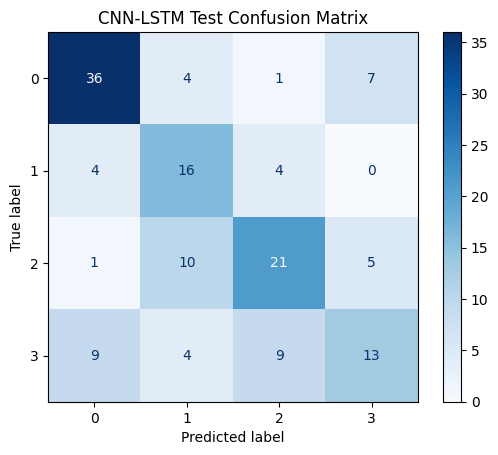

In [ ]:
# Optimizer: use BEST optimizer and learning rate
lr = best_hyperparams['lr']
optimizer_name = best_hyperparams['optimizer']

if optimizer_name == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
elif optimizer_name == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

#training
num_epochs = 300
best_val_loss = np.inf
patience = 20  #early stopping patience
trigger_times = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        inputs = inputs.permute(0, 2, 1)  #(batch_size, channels=3, seq_len=200)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    #validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  #(batch_size, channels=3, seq_len=200)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    val_acc = 100 * correct / total

    scheduler.step(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     trigger_times = 0
    #     torch.save(model.state_dict(), "best_cnn_lstm_model.pth")
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print("Early stopping triggered!")
    #         break
torch.save(model.state_dict(), "best_cnn_lstm_model.pth")
#best model
model.load_state_dict(torch.load("best_cnn_lstm_model.pth"))

#test Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.permute(0, 2, 1)  # (batch_size, channels=3, seq_len=200)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

#confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("CNN-LSTM Test Confusion Matrix")
plt.show()


## trying out something

In [ ]:
model = CNN_LSTM(num_classes=4)

In [ ]:
model.load_state_dict(torch.load("best_cnn_lstm_model.pth", map_location="cpu"))

<All keys matched successfully>

In [ ]:
model.eval()

CNN_LSTM(
  (cnn_layers): Sequential(
    (0): Conv1d(3, 16, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)

In [ ]:
for x, y in train_loader:
    print(f"Input shape: {x.shape}")  #expecting: torch.Size([batch_size, 3, 200])
    print(f"Label shape: {y.shape}")  #checking label shape
    break  # Only need to inspect the first batch

Input shape: torch.Size([64, 200, 3])
Label shape: torch.Size([64])


In [ ]:
dummy_input = torch.randn(1, 200, 3)
dummy_input = dummy_input.permute(0, 2, 1)

In [ ]:
pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 70.6 MB/s eta 0:00:00


In [ ]:
#export to ONNX
torch.onnx.export(
    model,
    dummy_input,
    "cnn_lstm.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)